## Linear regression

This assignment is dedicated to Linear regression. 12 task, 30 points max.

By focusing on predicting different features of football players,
you will:
* gain understanding of mathematics behind Linear Regression model
* and become familiar with using `sklearn` library for solving this kind of tasks

In the assignment we will:
* build Linear regression models with 1 and many variables
* use both library methods and manual calculations using mathematical formulas
* implement main regression metrics to evaluate performance of our models
* explore limitations of classical linear regression

### Notes:
* do not modify `assert` blocks in code. They are used to check your results
    

### Data
- In this notebook we will work with Football Player attributes per each match played.
  
  Data is taken from [European Soccer Database](https://www.kaggle.com/hugomathien/soccer) dataset. 
  
  The table used is `Player_Attributes`.


### Materias

Start with the assignment first. Use materials below as references when needed.

* NumPy:
    - [quickstart](https://numpy.org/doc/stable/user/quickstart.html)
    - [api reference](https://numpy.org/doc/stable/reference/index.html)
    

* Pandas:
    - [10 minutes to pandas](https://pandas.pydata.org/docs/user_guide/10min.html)
    - guide on [groupby.transform](https://pandas.pydata.org/docs/user_guide/groupby.html#transformation). 
      used in one of tasks on data preprocessing
    - [cheat sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
    

* sklearn:
    - [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) class documentation
    - guide on [Linear models](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)


* Matplotlib:
    - [cheatsheet](https://matplotlib.org/cheatsheets/)
    - examples of [main plot types](https://matplotlib.org/stable/plot_types/index.html)
    - [scatter plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) documentation

In [1]:
import os

import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = 'raise'  # forbid chained assignment to prevent implicit errors

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 6)  # set default figure size

import seaborn as sns
sns.set(font_scale=1.1)  # increase default font scale and set seaborn's plot style

from typing import List, Iterable

## Data Processing

In [2]:
data_root_dp = os.path.join('..', '..', 'RS School', '3_linear_regression')  # change to yours path
print(f'data_root_dp: "{data_root_dp}"')

data_root_dp: "..\..\RS School\3_linear_regression"


### read the raw SQL data
* you can run this code only once.<br>
  it will read `.sqlite` file and save extracted data to a more handy `.csv` format

In [3]:
import sqlite3

# open connection to .sqlite file
data_sql_fp = os.path.join(data_root_dp, 'database.sqlite')
print(f'will read from: "{data_sql_fp}"')
con = sqlite3.connect(data_sql_fp)

df = pd.read_sql('select * from Player_Attributes', con)  # run SQL-query
print(f'shape: {df.shape}')
con.close()  # close connection to .sqlite file

# save to .csv
out_fp = os.path.join(data_root_dp, 'tmp', 'player_attributes.csv')
os.makedirs(os.path.dirname(out_fp), exist_ok=True)  # create directories if needed
print(f'will save to: "{out_fp}"')
df.to_csv(out_fp, index=False)

will read from: "..\..\RS School\3_linear_regression\database.sqlite"
shape: (183978, 42)
will save to: "..\..\RS School\3_linear_regression\tmp\player_attributes.csv"


### read the  data

In [4]:
data_player_attributes_fp = os.path.join(data_root_dp, 'tmp', 'player_attributes.csv')
print(f'reading from: "{data_player_attributes_fp}"')
df = pd.read_csv(data_player_attributes_fp)
print(df.shape)

reading from: "..\..\RS School\3_linear_regression\tmp\player_attributes.csv"
(183978, 42)


In [5]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

### basic data processing

In [6]:
# there are 3 'id' columns in data. 
# we will use 'player_api_id' only
# and drop other 'id' columns.
redundant_key_columns = ['id', 'player_fifa_api_id']

# also we will drop categorical columns for this task.
categorical_columns = ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate']

cols_to_drop = redundant_key_columns + categorical_columns
print(f'will drop following columns: {cols_to_drop}')
df.drop(columns=cols_to_drop, inplace=True)

# rename 'player_api_id' column to shorter one: 'id'.
df.rename(columns={'player_api_id': 'id'}, inplace=True)

# cast string values to datetime
df['date'] = pd.to_datetime(df['date'])

# drop records that contain only NaNs in features
all_features = set(df.columns).difference(['id', 'date'])  # all columns without key columns
df.dropna(subset=all_features, how='all', inplace=True)

print(f'df.shape: {df.shape}')

will drop following columns: ['id', 'player_fifa_api_id', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate']
df.shape: (183142, 37)


In [7]:
# the dataset we're working with migh get updated in future (new records might be added).
# thus we remove any records with date larger than the current max date in data (2016-07-07)
# for compatibility with current version of notebook.
df.drop(index=df[df['date'] > '2016-07-07'].index, inplace=True)
print(df.shape)

(183142, 37)


### drop duplicates

* we should **ALWAYS** understand what our data represents


* here we are dealing with Football Player attributes per each match played.

  so we expect the data to have `(id, date)` as a key
  
  
* let's check whether our assumption holds

In [8]:
df.duplicated(['id', 'date']).value_counts()

False    183142
dtype: int64

* there are no duplicates if considering `(id, date)` pair as a key

In [9]:
df.duplicated('id').value_counts()

True     172082
False     11060
dtype: int64

* and there are duplicates if considering only `id` column as a key

* so our assumption holds. but let's work only with latest stats for each player

#### Task 1. Keep only latest data for each player (1 point)

* HINT: you can use 

  `df[<new_column>] = df.groupby(<key_to_aggregate>)[<column>].transform('max')` 
  
  to get the `max` value of `<column>` for each group specified by `<key_to_aggregate>` columns.
  
  then you'll have to filter rows using `<column>` and `<new_column>` values
  

* don't forget to remove any additional columns you introduce here

In [10]:
# your code here

df['Latest_Date'] = df.groupby('id')['date'].transform('max')
df = df.drop(index=df[df.date!=df.Latest_Date].index)
df = df.drop(columns=['Latest_Date'])
print(df.shape)

(11060, 37)


In [11]:
assert df.duplicated(['id']).sum() == 0
assert df.shape == (11060, 37)

In [12]:
# no longer need 'id' and 'date' columns
df.drop(columns=['id', 'date'], inplace=True)

### NaNs

In [13]:
df.isna().sum()

overall_rating          0
potential               0
crossing                0
finishing               0
heading_accuracy        0
short_passing           0
volleys               478
dribbling               0
curve                 478
free_kick_accuracy      0
long_passing            0
ball_control            0
acceleration            0
sprint_speed            0
agility               478
reactions               0
balance               478
shot_power              0
jumping               478
stamina                 0
strength                0
long_shots              0
aggression              0
interceptions           0
positioning             0
vision                478
penalties               0
marking                 0
standing_tackle         0
sliding_tackle        478
gk_diving               0
gk_handling             0
gk_kicking              0
gk_positioning          0
gk_reflexes             0
dtype: int64

* do you see any pattern in how NaNs are distributed?

There are the same number 478 of NaNs for the `volleys`, `curve`, `agility`, `balance`, `jumping`, `vision`, and `sliding_tackle` columns. I suppose that the NaNs in these columns are for the same 478 players.

In [14]:
df.isna().sum(axis=1).value_counts()

0    10582
7      478
dtype: int64

#### Task 2. Drop rows that contain NaNs (1 point)

In [15]:
df.dropna(inplace=True)

In [16]:
assert df.isna().sum().sum() == 0

In [17]:
df.shape

(10582, 35)

## Task 3. Implement main regression metrics yourself (up to 4 points):
* Mean Squared Error (mse) - **(1 point)**
* Mean Absolute Error (mae) - **(1 point)**
* Mean Absolute Percentage Error (mape) - **(1 point)**
* R-squared (r2) - **(1 point)**


#### bonus point: MAPE is implemented in such way to take possible 0 in `y_true` into account
Hints:

* you should divide on 
  $ \hat{y}_{true} = (\hat{y}_{true}^{(0)}, \hat{y}_{true}^{(1)}, ..., \hat{y}_{true}^{(n)}) $,
  
  where $ \ \ \hat{y}_{true}^{(i)} = max(\ \ | y_{true}^{(i)} |, \ \ \epsilon), \ \ \epsilon > 0, \ \ y_{true}^{(i)} \in \mathbb R $
  

* for compatibility with `sklearn` take 

  `eps = np.finfo(np.float64).eps`
  
  
#### bonus point: $R^2$ is implemented in such way to take possible 0 in numerator and denominator into account
Hints:

* recall the formula: $ R^2 = 1 - \dfrac{SS_{residuals}}{SS_{total}} $


* you should return:

    $
    \begin{cases}
     R^2 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} \ne 0 
     \\
     0 & \text{ if } SS_{residuals} \ne 0 \text{ and  } SS_{total} = 0 
     \\
     1 & \text { otherwise }
    \end{cases}
    $
    

* for a better understanding of $R^2$ coefficient 
  try to explain to yourself why we return those values in each of edge cases

* When we return 1:
  there is only one way how 𝑆𝑆𝑟𝑒𝑠𝑖𝑑𝑢𝑎𝑙𝑠 can be equal to zero - it is when each y_true(i) and all y_pred(i) are the same, so their difference is equal to zero. So as R-squared is by definidion is a statistical measure of how well the regression predictions approximate the real data points, we return 1, because the prediction is the same as the true result.
* When we return 0: 
  there is only one way how 𝑆𝑆𝑡𝑜𝑡𝑎𝑙 can be equal to zero - it is when each y_true(i) is the same as mean of y_true, whiсh means that y_true is a constant and forms a constant line parallel to the X-axis. It means that there's no linear dependency between variables, so we return 0.

In [18]:
# we use '*' in the beggining of each function signature
# to forbid positional arguments and enforce the use of kwargs.
# this helps to avoid mistake when arguments are passed in wrong order.

# write down code instead of raising NotImplementedError in each of functions below.

def mse(*, y_true, y_pred):
    return 1/len(y_true) * sum((y_true - y_pred)**2)
    
def mae(*, y_true, y_pred):
    return 1/len(y_true) * sum(abs(y_true - y_pred))
    
def mape(*, y_true, y_pred):
    eps = np.finfo(np.float64).eps
    return 1/len(y_true) * sum(abs(y_true - y_pred)/np.maximum(y_true, eps))
    
def r2(*, y_true, y_pred):
    if sum((y_true - y_pred)**2) != 0 and sum((y_true - (sum(y_true)/len(y_true)))**2) !=0:
        return 1 - sum((y_true - y_pred)**2)/sum((y_true - (sum(y_true)/len(y_true)))**2)
    elif sum((y_true - y_pred)**2) != 0 and sum((y_true - (sum(y_true)/len(y_true)))**2) ==0:
        return 0
    else:
        return 1

### Validate your implementations are correct

* we'll use synthetic data for this task


In [19]:
from sklearn.metrics import (
    mean_squared_error as mse_lib, 
    mean_absolute_error as mae_lib,
    mean_absolute_percentage_error as mape_lib,
    r2_score as r2_lib
)

In [20]:
def compare_metrics(fn, fn_lib, y_true, y_pred, n_digits=9):
    """ Print and compare values of custom and library functions using given precision. """
    m_fn = fn(y_true=y_true, y_pred=y_pred)
    m_fn_lib = fn_lib(y_true=y_true, y_pred=y_pred)
    print(f'{fn.__name__} custom : {m_fn}')
    print(f'{fn.__name__} library: {m_fn_lib}')
    print()
    assert round(m_fn, n_digits) == round(m_fn_lib, n_digits)

#### a case with a good fit

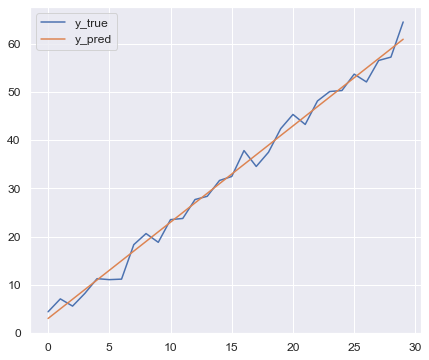

In [21]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [22]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 3.157646295484166
mse library: 3.157646295484166

mae custom : 1.5235549509466502
mae library: 1.52355495094665

mape custom : 0.0821155166740815
mape library: 0.0821155166740815

r2 custom : 0.9897145603880337
r2 library: 0.9897145603880337

all tests passed


#### 0s in target. MAPE should explode

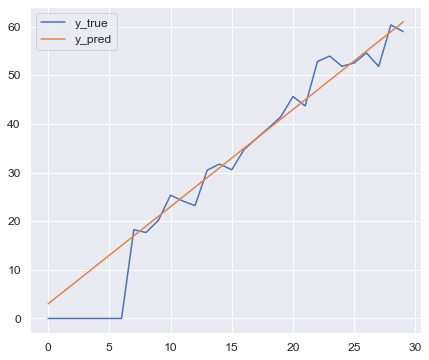

In [23]:
n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_true[:7] = 0
y_pred = 2 * x + 3

plt.plot(x, y_true, label='y_true')
plt.plot(x, y_pred, label='y_pred')
plt.legend();

In [24]:
compare_metrics(mse, mse_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mae, mae_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(mape, mape_lib, y_true=y_true, y_pred=y_pred)
compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('all tests passed')

mse custom : 27.127338122145026
mse library: 27.127338122145026

mae custom : 3.466636889644595
mae library: 3.466636889644595

mape custom : 9457559217478042.0
mape library: 9457559217478042.0

r2 custom : 0.9346188181828882
r2 library: 0.9346188181828882

all tests passed


#### edge cases for R2

In [25]:
# constant target value

n = 30
x = np.arange(n)
y_true = np.repeat(15, n)
y_pred = 2 * x + 3

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 0
r2 library: 0.0

success


In [26]:
# perfect fit

n = 30
x = np.arange(n)
y_true = 2 * x + 3 + np.random.normal(loc=0, scale=2, size=n)
y_pred = y_true

compare_metrics(r2, r2_lib, y_true=y_true, y_pred=y_pred)
print('success')

r2 custom : 1
r2 library: 1.0

success


### Define helper functions

In [27]:
def get_metrics(*, y_true, y_pred) -> pd.Series:
    """ A helper function to return all metrics for given labels and predictions. """
    
    # if you didn't implement some metrics, comment them out for this function to work.
    return pd.Series({
        'mse': mse(y_true=y_true, y_pred=y_pred),
        'mae': mae(y_true=y_true, y_pred=y_pred),
        'mape': mape(y_true=y_true, y_pred=y_pred),
        'r2': r2(y_true=y_true, y_pred=y_pred),
    })

In [28]:
def fit_and_evaluate(model, x_train, y_train, x_test, y_test) -> pd.DataFrame:
    """ 
    A helper function to: 
    * fit a passed model
    * and return metrics on train and test sets.
    """
    # fit the model
    model.fit(x_train, y_train)
    
    # return metrics as pd.DataFrame
    m = pd.DataFrame([
        get_metrics(y_true=y_train, y_pred=model.predict(x_train)),  # metrics for train set
        get_metrics(y_true=y_test, y_pred=model.predict(x_test))     # metrics for test set
    ], index=['train', 'test']
    )
    
    return m

## train/test split

* Split the data we have into Train and Test splits with 80%/20% proportion

In [29]:
print(df.shape)
ix_split = int(0.8 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(8465, 35) (2117, 35)


In [30]:
def get_train_test_data(features: List[str], target: str) -> tuple:
    """
    Return x_train, y_train, x_test, y_test using 
    * global train/test split 
    * features and target provided.
    """
    # in general, it's a bad practice to use global variables. 
    # however, we use it here with caution for simplicity.
    return (
        DF_TRAIN[features].copy(), DF_TRAIN[target].copy(), 
        DF_TEST[features].copy(), DF_TEST[target].copy()
    )

## Linear regression with 1 variable

* Let's start with Linear Regression that predicts target variable 
  using only 1 predictor (independent variable)  

* We will try to predict `dribbling` variable using `short_passing` as a predictor

In [31]:
target = 'dribbling'
features = ['short_passing']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

### Let's visualize our data first

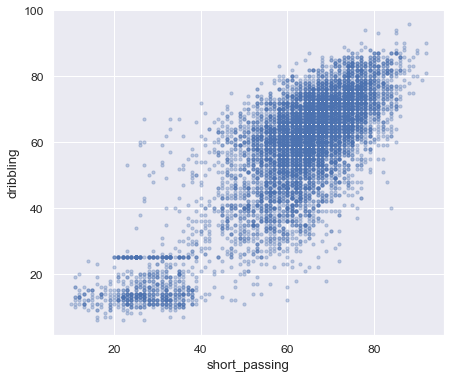

In [32]:
plt.scatter(x=x_train, y=y_train, alpha=0.3, s=10);
plt.xlabel('short_passing');
plt.ylabel('dribbling');

* do you notice anything interesting on this plot?
* if so, how can we use it later to generate more accurate predictions?

When the short_passing value is less than 40 the dribbling value in mast cases stays at the same level (about 20). But when the for the values of short_passing greater than 40, there is a positive linear relationship between short_passing and dribbling.

### Task 4. Compute Pearson correlation coefficient between feature and target (1 pont)
Hint: you can use either `pd.Series.corr` method or `np.corrcoef` function

In [33]:
pearson = np.corrcoef(df.short_passing, df.dribbling)
print('Pearson correlation coefficient between short_passing and dribbling: ', pearson[0][1])

Pearson correlation coefficient between short_passing and dribbling:  0.8129375578604561


### Solve using `sklearn`

* we will use `LinearRegression` class from `sklearn` library 
  to fit a linear regression model and use it to generate prediction

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [36]:
model_intercept = model.intercept_
model_slope = model.coef_[0]
print(f'model_intercept: {model_intercept}')
print(f'model_slope: {model_slope}')

model_intercept: -6.211029905026031
model_slope: 1.0366141627766248


* use fitted model to get predictions for test set

In [37]:
model_preds = model.predict(x_test)
model_preds

array([55.98581986, 65.31534733, 44.58306407, ..., 62.20550484,
       54.9492057 , 76.71810312])

In [38]:
print(type(model_preds))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


* explore model quality on test set.

In [39]:
print('model metrics on test set')
metrics_test_1 = get_metrics(y_true=y_test.array, y_pred=model_preds) # turning y_test series into an array
metrics_test_1

model metrics on test set


mse     108.345801
mae       8.173553
mape      0.205500
r2        0.681477
dtype: float64

* can you explain what those metic values mean?

* mse = 108.345801 - means that on average squared difference of actual values and predicted values amounts to 108.345801.
* mae = 8.173553 - means that on average predicted values differ from actual values by 8.173553
* mape = 0.205500 - means that on average difference between predicted values and actual values amounts to 20,55%
* r2 = 0.681477 - means that 68,1477% of variation of a dependent variable (dribbling) is explained by the independent variable (short_passing) in the regression model.

#### Task 5. Calculate predictions for test set manually (1 point)

Above we used `LinearRegression.predict()` method to obtain predictions. 
Now let's do it manually!

Recall Linear Regression formula:

* $ \hat{y} = w_0 + w_1 \cdot x, $ 

    where:
    * $w_0$ is an intercept
    * $w_1$ is a slope
    * $x$ is a predictor
    * $\hat{y}$ is a predicted variable
  

* use intercept and slope values from fitted LinearRegression model

In [40]:
# use `x_test` for calculations as is (it's a DataFrame with 1 column).
# do not convert it to Series or numpy array.

model_manual_preds = model_intercept + model_slope * x_test

In [41]:
assert isinstance(model_manual_preds, pd.DataFrame)

In [42]:
# ensure our manual predictions are the same as model generated
assert np.allclose(model_preds, model_manual_preds.iloc[:, 0].to_numpy())
print('success')

success


#### Task 6. Plot test data and predicted values (1 point)

* use `plt.scatter` function as in example above.
* first build scatter plot for test data
* then build scatter plot with model predictions
* add plot title, axis names and legend

Hints:
* use `alpha` parameter to control opacity and `s` parameter to control size of points.
  this will make plot more readable
* use `label` parameter to add label to each set of points added to scatter plot
* use different color for model predictions. control with parameter `color`

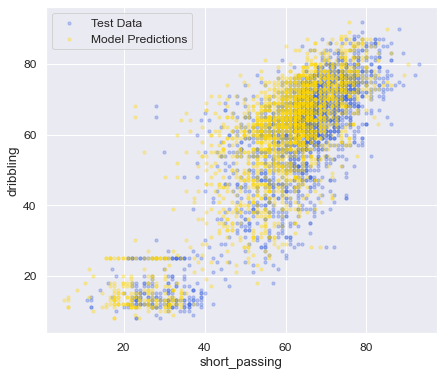

In [43]:
plt.scatter(x=x_test, y = y_test, alpha=0.3, s=10, color = 'royalblue');
plt.scatter(x=model_preds, y=y_test, alpha=0.3, s=10, color = 'gold');
plt.xlabel('short_passing');
plt.ylabel('dribbling');
plt.legend(['Test Data', 'Model Predictions']);

### Task 7.  Fit regression model manually (3 points)

So far we have used `sklearn` library to fit linear regression model and obtain predictions. Good job!

Recall the formula of Linear regression for 1 variable:

* $ \hat{y} = w_0 + w_1 \cdot x $

Now let's try to fit the model **ourselves**.

### Theory

Assume our dataset consists of _n_ samples.

To fit a Linear regression model means to find the best set of parameters - 
$(w_0, w_1)$ that minimizes a **Loss function**.<br>
In case of Linear regression we choose **Residual sum of squares (RSS)** as a Loss function:

* $ L(w, x, y) = RSS(w, x, y) = \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

That is conceptually the same as minimizing Mean squared error (MSE):

* $ MSE(w, x, y) = \dfrac{1}{n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i ) ^ 2 \rightarrow min $

Here:
* $y = (y_0, y_2, ..., y_{n-1}) $ - is a vector of target values we want to predict.
  1 value per each sample in our dataset that consists of _n_ samples
* $\hat{y} = (\hat{y}_0, \hat{y}_2, ..., \hat{y}_{n-1}) $ - is a vector of predictions 
* $\hat{y}_i = w_0 + w_1 \cdot x_i$ - is an individual prediction for _i_-th sample in a dataset

---

Best parameters $w_0$ and $w_1$ can be found using **following formulas**:

* $w_0 = \bar{y} - w_1 \cdot \bar{x}$


* $w_1 = \dfrac{\sum_{i=0}^{n-1}(x_i - \bar{x}) y_i}{\sum_{i=0}^{n-1}(x_i - \bar{x})^2}$


* where:
 * $\bar{x} = \dfrac{1}{n} \sum_{i=0}^{n-1}x_i$ - is the mean of vector $x$
 
 * $\bar{y} = \dfrac{1}{n} \sum_{i=0}^{n-1}y_i$ - is the mean of vector $y$
 
You should use these formulas to find the best model parameters in this task.
 
---

If you want to learn more you can refer to 
[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) wiki-page.

It contains analagous formula for $w_1$ coefficient that is conceptually the same 
(so it's not a bug in our formula provided above).

### Implementation

* convert pd.DataFrame and pd.Series (`x_train` and `y_train` respecitvely) to numpy-arrays

In [44]:
x = x_train.iloc[:, 0].to_numpy()
y = y_train.to_numpy()

* calculate model parameters ($w_1$ - slope and $w_0$ - intercept) using formulas given above

In [45]:
# your code here:
manual_slope = sum((x - np.mean(x))*y)/sum((x - np.mean(x))**2)
manual_intercept = np.mean(y) - manual_slope * np.mean(x)

In [46]:
print(f'manual_intercept: {manual_intercept}')
print(f'manual_slope: {manual_slope}')

manual_intercept: -6.211029905026301
manual_slope: 1.0366141627766292


In [47]:
assert round(model_intercept, 9) == round(manual_intercept, 9)
assert round(model_slope, 9) == round(manual_slope, 9)
print('success')

success


## Linear regression with multiple variables

* Now let's use Linear Regression model that uses multiple variables

* We will try to predict `dribbling` variable using 
  `['ball_control', 'short_passing', 'strength', 'sprint_speed']` features

In [48]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [49]:
print(type(target))

<class 'str'>


### Let's explore the data first

In [50]:
cols = features + [target]
print(cols)

['ball_control', 'short_passing', 'strength', 'sprint_speed', 'dribbling']


#### Task 8 (1 point)

Build pairwise correlation matrix for selected features and target. Visualize it with heatmap.

Hints:
* use `DF_TRAIN` to build statistics (`x_train` contains only features. target is in `y_train`)
* use `pd.DataFrame.corr()` to build correlation matrix
* use `sns.heatmap` to build heatmap from correlation matrix. 
  * use `center` parameter to center your heatmap's colormap at 0
  * use diverging colormap (`cmap` parameter)<br>
    you can find the list of diverging colormaps
    [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging)<br>
    the reason is that we need to easily find both negative and positive correlations.
  * use `annot` parameters to add numbers to the plot.
* you can print `pd.DataFrame` and build plot in the same cell.<br> 
  use `display(...)` function that accets `pd.DataFrame` before building the plot
  
You can refer to [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) documentation

,ball_control,short_passing,strength,sprint_speed,dribbling
ball_control,1.000000,0.904857,-0.024422,0.572677,0.919271
short_passing,0.904857,1.000000,0.039196,0.450801,0.809405
strength,-0.024422,0.039196,1.000000,-0.203386,-0.150197
sprint_speed,0.572677,0.450801,-0.203386,1.000000,0.656453
dribbling,0.919271,0.809405,-0.150197,0.656453,1.000000


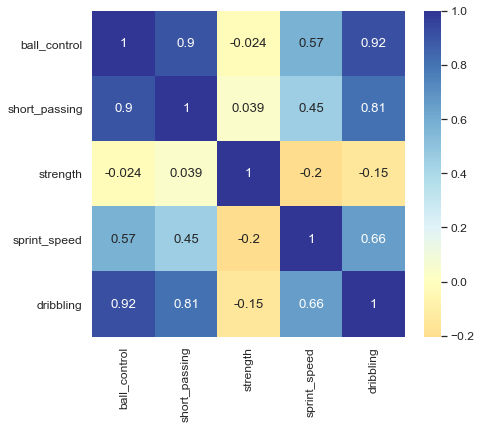

In [51]:
# your code here
correlation_matrix = DF_TRAIN[cols].corr()
display(correlation_matrix)
sns.heatmap(data = correlation_matrix, center = 0, cmap = 'RdYlBu', annot = True);

* what can you say about selected feature set using this correlation matrix?

The target (dribbling) has strong positive relationship with the ball_control, short_passing, and sprint_speed features, because Pearson’s correlation coefficient values are greater than 0.5.

The relationship between dribbling and the strength feature is negative and the relationship strenght is from week to medium, because Pearson’s correlation coefficient value is greater than 0.1 but less than 0.3.

#### Let's build pairplots for features and target

* `plot_kws` parameter accepts dictionary of keyword arguments 
  that are passed to bivariate plotting function (`sns.scatterplot` in this case)


* we set size to 7 (using `s` parameter) to make points smaller and see patterns clearly.<br>
  you can compare this to running with not `plot_kws` passed.
  

* `alpha` parameter also helps to see data distribution clearly


* you can also experiment with `kind` parameter - refer to
  [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
  documentation for possible values.

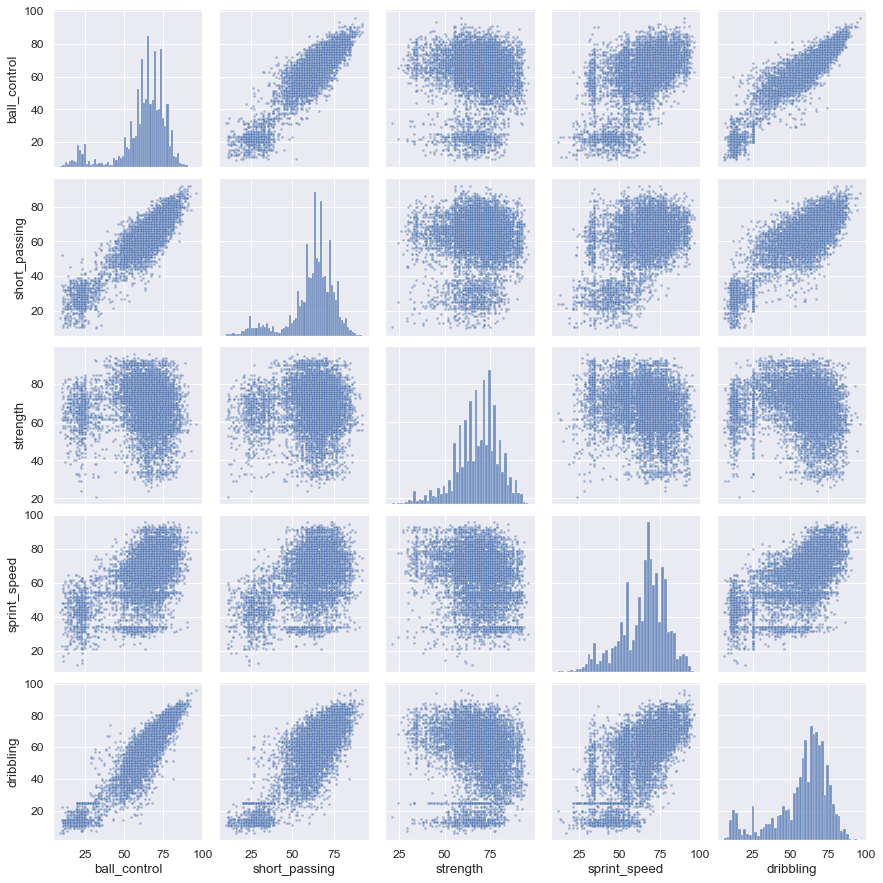

In [52]:
sns.pairplot(DF_TRAIN[cols], plot_kws={'s': 7, 'alpha': 0.5});

* what can you say about these scatterplots? is there anything we can use later?

The scatterplots visualize relationships between target and features. For example the strong linear relationship between dribbling and ball_control indicated with high Pearson’s correlation coefficient (0.92) can be seen in the scatterplot.
Similarly for the features which have weak linear relationship indicated with low Pearson’s correlation coefficient (like between the strength feature and all other features), we can see that the scatterplots doesn't show any linear relationship between variables.

The strength feature isn't highly correlated with the target. Maybe we can use this later to exclude the strength feature from the multiple regression to make our model more accurate.

The short_passing and ball_control features are highly correlated. This could mean that there is multicollinearity affects the acuracy of the regression model. Maybe we can try to exclude one of the highly correlated features and check if it'll improve the model.

 ### Solve using `sklearn`

In [53]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [54]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: -4.410760994496663
model_coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


* how to interpret these model parameters?

* model_intercept = -4.410760994496663 - means that the regression lines of the relationship between the target and each feature cross the y-axis at point -4.410760994496663.
* model_coef = [ 0.98220522 -0.03927767 -0.14440889  0.20772844] - represents the list of coefficients for regression model which shows the relationship between the target and each selected feature. Each of the model coefficients is interpreted as the estimate change in target variable (dribbling) corresponding to a one unit change in a feature, when all other features are held constant.

* use fitted model to get predictions for test set

In [55]:
model_preds = model.predict(x_test)
model_preds

array([44.30711902, 61.5246943 , 56.23794497, ..., 64.14903371,
       57.22105591, 75.15698321])

* explore model quality on test set.

In [56]:
print('model metrics on test set')
metrics_test_2 = get_metrics(y_true=y_test.array, y_pred=model_preds)
metrics_test_2

model metrics on test set


mse     38.192447
mae      4.459334
mape     0.112574
r2       0.887719
dtype: float64

* Let's compare `metrics_test_2` against `metrics_test_1`

In [57]:
# combine 2 series in 1 dataframe
metrics_comparison = metrics_test_1.to_frame('LR_1v').join(metrics_test_2.rename('LR_mv')).T
metrics_comparison

,mse,mae,mape,r2
LR_1v,108.345801,8.173553,0.205500,0.681477
LR_mv,38.192447,4.459334,0.112574,0.887719


C:\Users\a.rusakovich\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


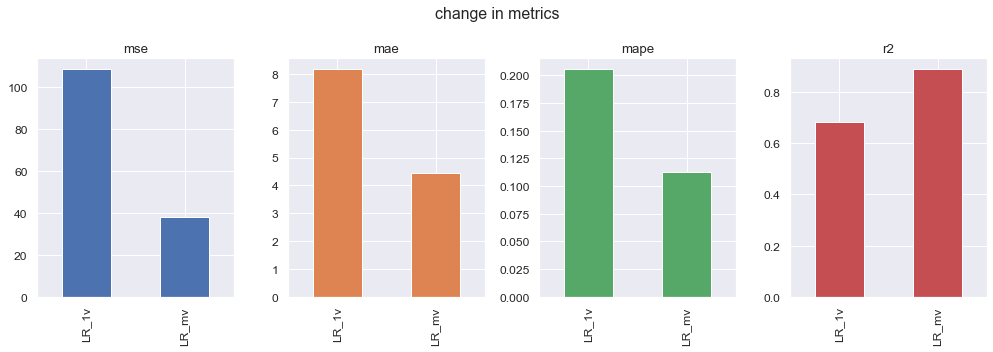

In [58]:
fig, ax = plt.subplots(figsize=(14, 5))  # specify figure size
metrics_comparison.plot(
    kind='bar', layout=(1,4), subplots=True, 
    title='change in metrics', legend=False, ax=ax
);
fig.tight_layout();  # prettify subplots. read more in documentation if interested

* did our Linear regression model improve after we've added more features?

Yes, the Linear regression model improved after we've added more features. The mse, mae, mape metrics decreased, because the difference between actual values and predicted values of the target decreased. R-squarred, on the contrary, increased, so now the 88.7719% of variation of the target variable (dribbling) is explained by the independent variables (ball_control, short_passing, strength, sprint_speed) in the regression model.
All of this indicate that the regression model has become more accurate.

### Task 9. Implement Linear regression model with multiple variables yourself (5 points)

Okay, we've fitted Linear regression model using `sklearn` library. Now let's do the math ourselves!

### Prerequisites

For this task you will need to:
* have basic understanding of Linear algebra (operations with vectors and matrices)
* know how to perform matrix multiplication, transposition and inversion using `numpy` 
  (these functions can be found in NumPy documentation)
* carefully read the theory below and refer to wiki / textbooks / other sources if required

---

### Theory and notation

When we extend Linear regression model on case with $m$ variables we get the following formula:

* $ \hat{y}
= 1 \cdot w_0 + x_1 \cdot w_1 + x_2 \cdot w_2 + ... + x_m \cdot w_m
= \sum_{i=0}^{m} x_i w_i
$,

where:
* $x = (1, x_1, ..., x_m)$ is an _(m+1)_-element feature vector. 
    * $x_0 = 1$ is a special term introduced in the beginning of feature vector 
      to add intercept to Linear regression model
    * $x_i, i=\overline{1,m}$ is an _i_-th feature value.
* $w = (w_0, w_1, ..., w_m)$ is an _(m+1)_-element parameter vector
    * $w_0$ - the first value of parameter vector - is referred to as **intercept**
* $\hat{y}$ is a predicted value

----

The formula above is used to calculate predictions for 1 sample.
i.e. we predict 1 scalar $\hat{y}$ from 1 feature vector $x$.

If we have a dataset of $n$ samples $(x, y)$ - we get a system of linear equations:

$
\begin{cases}
 \hat{y}^{(0)} = \sum_{i=0}^{m} x_i^{(0)} w_i \\
 \hat{y}^{(1)} = \sum_{i=0}^{m} x_i^{(1)} w_i \\
 ... \\\
 \hat{y}^{(n-1)} = \sum_{i=0}^{m} x_i^{(n-1)} w_i
\end{cases}
$

Such system can be rewritten in a succinct matrix form (a way that we write equations in Linear algebra):

* $ \hat{y} = X \cdot w $

And the task of minimizing Residual sum of squares (RSS) now looks:
* $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = \|y - X \cdot w \|_2^2 \rightarrow min $

Here:
* $y = (y^{(0)}, y^{(1)}, ..., y^{(n-1)})$ now denotes a **vector of target values** we want to predict<br>
  $y^{(j)}$ is a target value for _j_-th sample in a dataset.
* $\hat{y} = (\hat{y}^{(0)}, ..., \hat{y}^{(n-1)})$ 
  now denotes a **vector of predictions** <br>
  $\hat{y}^{(j)}$ denotes a predicted value for _j_-th sample in a dataset
* $X$ is a **feature matrix** of shape $n \times (m+1)$. <br>
  _n_ rows correspond to _n_ data samples and _m+1_ columns correspond to _m+1_ features that describe each sample.
* $w = (w_0, w_1, ..., w_m)$ is still a **model parameter vector**
* $X \cdot w$ denotes a **matrix-by-vector** multiplication
* $\|\cdot\|_2$ denotes an $L_2$-norm and is basically a square root of sum of squares of vector elements:<br>
  $\|a\|_2 = \sqrt{a_0^2 + a_1^2 + ... + a_{n-1}^2}$ for an _n_-component vector _a_.
  Thus, RSS means the same as before:<br>
  $ RSS(w, x, y) = \|y - \hat{y}\|_2^2 = 
  (y^{(0)} - \hat{y}^{(0)})^2 + (y^{(1)} - \hat{y}^{(1)})^2 + ... + (y^{(n-1)} - \hat{y}^{(n-1)})^2 = 
  \sum_{j=0}^{n-1} (y^{(j)} - \hat{y}^{(j)})^2
  $

Note:
* we now use **superscripts** $\hat{y}^{(i)}$ instead of **subscripts** $\hat{y}_i$ as before
  to denote _i_-th sample in a dataset
* it is done to be able to refer both to sample index (denoted by superscript)
  and feature index (denoted by subscript) in a single equation. 
  
  Thus:
  * $x^{(j)} = (1, x^{(j)}_1, x^{(j)}_2, ..., x^{(j)}_{m})$  now denotes 
    _j_-th feature vector in a dataset with _m+1_ features
  * $x_i^{(j)}$ denotes an _i_-th feature value of _j_-th feature vector
  * $X = 
  \begin{bmatrix}
      1 & x^{(0)}_1 & x^{(0)}_2 & ... & x^{(0)}_{m} \\
      1 & x^{(1)}_1 & x^{(1)}_2 & ... & x^{(1)}_{m} \\
      ... \\
      1 & x^{(n-1)}_1 & x^{(n-1)}_2 & ... & x^{(n-1)}_{m}
    \end{bmatrix}
    $ is an $n \times (m+1)$ feature matrix. <br><br>
    $X$ can also be written as a column-vector of feature vectors:<br><br>
    $ X = \begin{bmatrix}x^{(0)} \\ x^{(1)} \\ ... \\ x^{(n-1)}\end{bmatrix} $

---

### Fit 

**<TL;DR\>** Enough notation! How can we fit this model?

By minimizin Residual sum of squares (RSS) for a Linear regression equation in a matrix form
we now get a **single** formula to find **all model parameters**!
* $ w = (X^T X)^{-1} X^T y $

Beautiful, isn't it? <br>
Recall, how we got individual formulas for $w_0, w_1$ in case of Linear regression with 1 predictor.<br>
Now we can find the whole parameter vector _w_ at once!

In the formula above:
* $X$ is an $n \times (m+1)$ dimensional feature matrix


* $X^T$ is a **transposed** feature matrix.<br>
  Transposition is a mathematical operation of "swapping" matrix dimensions.<br>
  So $X^T$ is an $(m+1) \times n$ dimensional matrix  


* $ (X^T X)^{-1} $ is the inverse matrix of $ X^T X $

Notes:
* Because of inversion operation performed on $X^T X$ matrix 
  there are difficulties in fitting Linear regression model in some cases.
  
  We will talk more on that later in the assignment.

---
    
If you want to learn more you can refer to 
[Linear least squares](https://en.wikipedia.org/wiki/Linear_least_squares)
wiki-page.

### Implementation

* implement `LRMatrixForm` class and `add_ones_column` function.<br>
  docstrings describe what each function/method should do - so read the docstrings.
  
  
* [what is a docstring?](https://www.python.org/dev/peps/pep-0257/#what-is-a-docstring)


Note:
* `LRMatrixForm` class must support 2 modes: **with** fitting intercept parameter and **without**.<br>
  The behavior is controlled by `fit_intercept` parameter passed to class constructor.

In [59]:
from sklearn.exceptions import NotFittedError

In [60]:
def add_ones_column(x):
    """ 
    Add column consisting of ones to the beginning of matrix `x`. 
    Used when fitting `LRMatrixForm` with `fit_intercept` param set to True.
    """
    # your code here:
    vector_ones = np.ones([x.shape[0], 1], dtype=np.int32) # create a vector that consists of ones: (1, 1, ..., 1)
    return np.hstack([vector_ones, x]) # add this vector to a matrix

class LRMatrixForm:
    """
    Class that encapsulates Linear regression model with multiplie variables.
    Calculations are performed using matrix formula.
    
    Use `fit()` method to fit the model on data.
    Use `predict()` method to calculate predictions when the model is fitted.
    """
    def __init__(self, fit_intercept: bool = True):
        """
        fit_intercept: 
        Whether to calculate the intercept for this model. 
        If set to False, no intercept will be used in calculations 
        (i.e. data is expected to be centered).
        """
        self.fit_intercept = fit_intercept
        self.w_ = None  # vector with all model parameters (intercept and weights)
    
    def fit(self, x_train: pd.DataFrame, y_train: pd.Series):
        X = x_train.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            # when creating a model with intercept term we need to extend feature matrix
            # with a column consisting of ones (1, 1, ..., 1).
            X = add_ones_column(X)
            
        # your code here to calculate model parameters:
        X_transposed = X.transpose()
        matrix_mult = np.matmul(X_transposed, X)
        inverse_matrix = np.linalg.inv(matrix_mult)
        inverse_matrix_mult = np.matmul(inverse_matrix, X_transposed)
        self.w_ = np.matmul(inverse_matrix_mult, y_train)
        
    @property
    def coef_(self):
        """ Property that returns model parameters without the intercept term. """
        if self.w_ is None:
            raise NotFittedError()
        # # your code here:
        if self.fit_intercept is not True:
            return self.w_
        if self.fit_intercept is True:
            return self.w_[1:]
    
    @property
    def intercept_(self):
        """ Property that returns intercept term from model parameters. """
        if self.fit_intercept is not True:
            return 0.0  # for compatibility with sklearn
        if self.w_ is None:
            raise NotFittedError()
        # your code here:
        if self.fit_intercept is True:
            return self.w_[0]
    
    def predict(self, x_test: pd.DataFrame):
        """ Generate predictions using fitted model parameters. """
        if self.w_ is None:
            raise NotFittedError()
        
        X = x_test.to_numpy()  # convert pd.DataFrame to numpy matrix
        
        if self.fit_intercept is True:
            X = add_ones_column(X)
            
        # your code here to calculate predictions
        return np.matmul(X, self.w_)

### Validate your implementation is identical to library version

In [61]:
lr_matrix_form = LRMatrixForm(fit_intercept=True)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.744076,4.423665,0.109928,0.879145
test,38.192447,4.459334,0.112574,0.887719


In [62]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: -4.41076099449437
coef: [ 0.98220522 -0.03927767 -0.14440889  0.20772844]


In [63]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values:

In [64]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean       -0.000265
std         6.181464
min       -19.832055
25%        -3.624840
50%        -0.929033
75%         2.657819
max        39.721074
Name: dribbling, dtype: float64

### Now let's compare `sklearn` model and yours with `fit_intercept=False`

In [65]:
model = LinearRegression(fit_intercept=False)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,38.001048,4.462836,0.111262,0.878322
test,38.417697,4.494385,0.114204,0.887057


In [66]:
lr_matrix_form = LRMatrixForm(fit_intercept=False)
fit_and_evaluate(lr_matrix_form, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,38.001048,4.462836,0.111262,0.878322
test,38.417697,4.494385,0.114204,0.887057


* Compare the metrics on a test set of a model fitted **with** intercept parameter 
  vs model fitted **without** intercept.
* Which model has a better performance? Can you explain why?

* with intercept parameter:            
    * mse = 38.192447
    * mae = 4.459334
    * mape = 0.112574
    * r2 = 0.887719
* without intercept parameter:
    * mse = 38.417697
    * mae = 4.494385
    * mape = 0.114204
    * r2 = 0.887057
    
The mse, mae, and mape metrics of the model fitted with intercept parameter are less than the mse, mae, and mape metrics of the model fitted without intercept. While the r2 metric of the model fitted with intercept parameter is greater than the r2 metric of the model fitted without intercept. It means that the model fitted with intercept parameter has a better performance than the model fitted without intercept.

In [67]:
print(f'intercept: {lr_matrix_form.intercept_}')
print(f'coef: {lr_matrix_form.coef_}')

intercept: 0.0
coef: [ 0.99382995 -0.05758452 -0.17865978  0.18315944]


In [68]:
assert np.allclose(model.predict(x_test), lr_matrix_form.predict(x_test))
assert round(model.intercept_, 9) == round(lr_matrix_form.intercept_, 9)
assert np.allclose(model.coef_, lr_matrix_form.coef_)

* let's take a look at difference between model predictions and target values again:

In [69]:
(model.predict(x_test) - y_test).describe()

count    2117.000000
mean        0.069583
std         6.199275
min       -20.437460
25%        -3.706841
50%        -0.888994
75%         2.766454
max        39.316868
Name: dribbling, dtype: float64

* compare this to the same statistics obtained with model fitted **with intercept**
* notice how the _mean_ value of difference changed

Comparing statistics obtained with model fitted with intercept and with model fitted without intercept, we can see that the 
model fitted with intercept shows slightly better results than the model fitted without intercept.
For the model fitted with intercept mean difference between model predictions and target values is equal to -0.000265. It means that on average the model predictions are less than target values. 
While for the model fitted without intercept mean difference is equal to 0.069583, which means that on average the model predictions are greater than target values. 
As the mean difference between model predictions and target  values for the model fitted without intercept is greater than for the model fitted with intercept, we can conclude that the model fitted with intercept works slightly better that without intercept.

## Limitations of Linear regression

Recall the formula to find Linear regression parameters in case of multiple variables:
* $ w = (X^T X)^{-1} X^T y $

As noted above, there might be difficulties with fitting Linear regression model
because of inverting $X^T X$ matrix.

Not every matrix can be inverted.

An example of such case is when 2 or more features have strong linear relationship between them.<br>
It means that one of variables can be **linearly predicted from the others with a substantial degree of accuracy**.<br>
Such situation is named **collinearitry** (in case of 2 related variables)
or **multicollinearity** (>2 related features).<br>

Collinearity is associated with high value of correlation coefficient between 2 related features.

You can refer to [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) 
wiki page to read more.

The intuition why multicollinearity is bad is that Linear Regression tries to capture 
a contribution of each individual feature to target independently of other features.
This is not possible with the data that has collinear features, 
as change in one such variable is always associated with change in other/others.

There are a whole bunch of really interesting thoughts that can help you 
to capture the intuition behind the concept of multicollinearity.<br>
You can find some of them 
[here](https://stats.stackexchange.com/questions/1149/is-there-an-intuitive-explanation-why-multicollinearity-is-a-problem-in-linear-r).

### Collinearity

* Let's construct and add a new feature to our dataset that is going to be _collinear_ with another one:

In [70]:
# select features as usual
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [71]:
def add_collinear_column(_df: pd.DataFrame, orig_col: str, new_col: str):    
    """ 
    Construct new column as a linear transform of another one + tiny noise.
    y = f(x) = a1 * x + a2 + noise.
    
    Alternatively, we could apply no linear transform at all (set a1=1, a2=0)
    And only add some noise to existing column. Results would be the same.
    """
    # linear transform
    _df[new_col] = 2 * _df[orig_col] + 3
    # add tiny normal noise
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

orig_col = 'sprint_speed'
new_col = 'sprint_speed_2'
add_collinear_column(x_train, orig_col, new_col)
add_collinear_column(x_test, orig_col, new_col)
features.append(new_col)

In [72]:
corr_coef = np.corrcoef(x_train[orig_col], x_train[new_col])[0, 1]
print(f'correlation between {orig_col} and {new_col}: {corr_coef}')

correlation between sprint_speed and sprint_speed_2: 0.9999999999935325


* As expected, correlation coefficient between collinear features 
  (`sprint_speed` and `sprint_speed_2`) is close to 1.<br>
  Thus they are highly correlated.

In [73]:
# visualize sample of train data
check = x_train.sample(5).copy()
# add helper column to see how much noise was added
check['sprint_speed_2_wo_noise'] = 2 * check['sprint_speed'] + 3
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,sprint_speed_2_wo_noise
33768,70.0,68.0,67.0,88.0,179.000047,179.0
1176,58.0,62.0,86.0,71.0,145.000026,145.0
57635,37.0,42.0,74.0,54.0,110.999973,111.0
63379,78.0,76.0,60.0,71.0,145.000026,145.0
35831,58.0,63.0,72.0,68.0,139.000168,139.0


### let's fit a Linear Regression model on this feature set:

In [74]:
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.741043,4.423839,0.109946,0.879155
test,38.198967,4.459916,0.112575,0.887700


* Both train and test metrics look reasonable
* Now let's explore model params:

In [75]:
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

intercept: 1646.037510261711
coef: [0.9823909007779237, -0.03947730483366332, -0.1443337442493202, 1100.50785555291, -550.1500752674175]


* Weights that correspond to `sprint_speed` and `sprint_speed_2` columns should have gone insanely high!


* That is not ok. Large weights and weights instability are the sign of 
    [**overfitting**](https://en.wikipedia.org/wiki/Overfitting).

    According to the definition, overfitting is:<br>
    "_the production of an analysis that corresponds too closely 
    or exactly to a particular set of data,<br>
    and may therefore fail to fit additional data 
    or predict future observations reliably_".
    
    
* But what does that mean? Let's try to generate predictions with our model.

### generate predictions using our fitted model

In [76]:
check = x_test.head(2).copy()
check[target] = y_test.head(2)
check['preds'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds
147541,51.0,60.0,68.0,52.0,106.999908,49.0,44.357258
147549,65.0,69.0,66.0,69.0,140.999924,59.0,61.565955


In [77]:
get_metrics(y_true=check[target], y_pred=check['preds'])

mse     14.069592
mae      3.604349
mape     0.069120
r2       0.437216
dtype: float64

* predictions look good, right? 

### but what if we change `sprint_speed` values a bit? let's add some small `delta`

In [78]:
delta = 1  # some small value
check['sprint_speed'] += delta
check['preds_2'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2
147541,51.0,60.0,68.0,53.0,106.999908,49.0,44.357258,1144.865113
147549,65.0,69.0,66.0,70.0,140.999924,59.0,61.565955,1162.073811


In [79]:
get_metrics(y_true=check[target], y_pred=check['preds_2'])

mse     1.208846e+06
mae     1.099469e+03
mape    2.053038e+01
r2     -4.835284e+04
dtype: float64

* Wow, new predictions doesn't look even close to the target!<br>
  Our model doesn't look like a good model anymore.
  

* That is exactly what overfitting is. <br>
  **We fail to obtain reasonable predictions when we apply our model on new data**.

### One might notice that we have changed only 1 of 2 collinear features
* Indeed, giant model weights that correspond to these 2 features, should cancel each one out<br>
  if relation between feature values stays the same.  

* Let's check this out.<br>
  We have performed following transform:<br>
  `sprint_speed_changed = sprint_speed + delta`<br>
  

* How should we change `sprint_speed_2` to match the same data distribution from train data?<br>
  
  Let's calculate (we will ignore the noise added):  
  `sprint_speed_2_changed - sprint_speed_2 = f(sprint_speed_changed) - f(sprint_speed) =`<br>
  `= a1 * sprint_speed_changed + a2 - (a1 * sprint_speed + a2) = a1 * delta`

In [80]:
# here we change the second of collinear features 
# using the same coefficient 
# that was used in linear transform in `add_collinear_column()` function.
# we don't need to add intercept coefficient as it cancels it out (you can do the math yourself).
check['sprint_speed_2'] += 2 * delta
check['preds_3'] = model.predict(check[features])
check

,ball_control,short_passing,strength,sprint_speed,sprint_speed_2,dribbling,preds,preds_2,preds_3
147541,51.0,60.0,68.0,53.0,108.999908,49.0,44.357258,1144.865113,44.564963
147549,65.0,69.0,66.0,70.0,142.999924,59.0,61.565955,1162.073811,61.773660


* In the last example we see that new predictions (`preds_3`) now look similar to the first ones <br>
  (`preds` - calculated before changing `sprint_speed` value)


* So, if values of collinear features change accordingly - we are safe, right? <br>
  How do your think, can we always rely on this assumtion?

### What just happened

* The answer to the question above is: **no, we can't**.
  
  
* Yes, we have checked that if collinear features values are changed accordingly 
  (i.e. their **initial relation is preserved**), <br>
  model predictions look reasonable and accurate.
  
  But this will not always be the case on the real data.
  
  We can't be sure that the data 
  that we apply our fitted model on (`x_test`, for example)<br>
  preserves **exactly the same data distribution** as the data that model was trained on (`x_train`).
  
  

**Why this happened?**

* When feature matrix contains collinear or multicollinear features (the problem of **multicollinearity**),
  inversion of such a matrix is numerically unstable.<br>
  This leads to large values and imprecise estimates of model parameters.

**How to detect multicollinearity**
* You should monitor your model weights. For example using $L_2$ norm:<br>
  $ L_2(w) = \|w\|_2 = \sqrt{w_1^2 + w_2^2 + ... + w_n^2} = \sqrt{\sum_{i=1}^{n} w_i^2} $<br>
  If any of model weights are huge - $L_2$ norm will also have large value.
  
  
* Monitor model performance on validation data. 
  If the metrics are poor and prediction look huge,<br>
  you should check if collinear features are present in train data.

**How to fix the issue**

* For each set of collinear features, keep only 1 of them and remove the rest.<br>
  The best regression models are those in which the predictor variables each correlate highly 
  with the target variable,<br>
  but correlate at most only minimally with each other.
  

* Combine collinear features into new ones

  
* Use regularization (will be covered later in the course).

### Task 10. Implement function to calculate $L_2$-norm. (1 point)
* Use formula above to implement $L_2$ norm

In [81]:
def l2_norm(arr: Iterable):
    # your code here
    return (sum(arr**2))**(1/2)

### Calculate $L_2$-norm value for current model
* you should get high value that represents large values of some model parameters

In [82]:
l2_norm(model.coef_)

1230.3591479454196

### Multicollinearity
  
* It's important to notice that in case of multicollinearity,
  correlation coefficient between each pair of related variables
  could be **not so high**.
  
  So **it may be hard to find multicollinear features in your data**.
  

* Let's visualize it in practice.

  We will build a new feature that has a strong linear relationship with 2 other features:
  $x_1 = a_0 + a_2 x_2 + a_3 x_3 + noise$

  We want to show that Linear regression model will still suffer from multicollinearity,<br>
  but correlation coefficients betweent each pair of multicollinear features will be **less close to 1**
  than it was in case of collinearity.

In [83]:
target = 'dribbling'
features = ['ball_control', 'short_passing', 'strength', 'sprint_speed']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

def add_collinear_column(_df: pd.DataFrame, col1: str, col2: str, new_col: str):    
    _df[new_col] = _df[col1] + _df[col2] + 5
    _df[new_col] += np.random.normal(loc=0, scale=0.0001, size=_df.shape[0])

add_collinear_column(x_train, col1='sprint_speed', col2='strength', new_col='foo')
add_collinear_column(x_test, col1='sprint_speed', col2='strength', new_col='foo')
features.append(new_col)

model = LinearRegression(fit_intercept=True)
m = fit_and_evaluate(model, x_train, y_train, x_test, y_test)
display(m)
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_.tolist()}')

,mse,mae,mape,r2
train,37.728343,4.424875,0.109962,0.879196
test,38.200473,4.460180,0.112610,0.887695


intercept: 6355.880149227555
coef: [0.9822506006723792, -0.03962823464790835, 1271.9135643039426, 1272.2659011765413, -1272.0579505715605]


* As before, model parameters for multicollinear features should be large

* Let's calculate $L_2$-norm value - it should also be large

In [84]:
l2_norm(model.coef_)

2203.305932991575

#### Task 11. Visualize correlation matrix for `x_train`  (1 point)
* Build annotated heatmap (use `annot` param to add values to plot, select diverging `cmap` and center it at 0)
* You should see that `foo` feature is correlated with ones it was created from,<br>
  but each of these correlation coefficients **is not so close to 1**

,ball_control,short_passing,strength,sprint_speed,foo
ball_control,1.000000,0.904857,-0.024422,0.572677,0.474099
short_passing,0.904857,1.000000,0.039196,0.450801,0.415056
strength,-0.024422,0.039196,1.000000,-0.203386,0.541851
sprint_speed,0.572677,0.450801,-0.203386,1.000000,0.712702
foo,0.474099,0.415056,0.541851,0.712702,1.000000


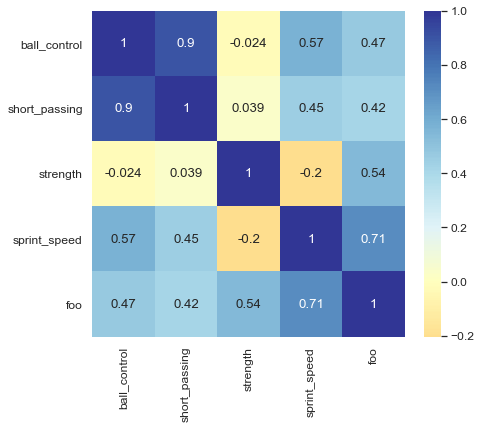

In [85]:
# your code here
correlation_matrix = x_train.corr()
display(correlation_matrix)
sns.heatmap(data = correlation_matrix, center = 0, cmap = 'RdYlBu', annot = True);

### Regularization

* The concept of regularization (that was mentioned above) is simple.

  We modify Loss function (RSS in case of Linear regression) in such a way<br>
  to penalize for large values of model parameters.
  
  
* $L_2$ regularization, also named as 
  [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization), 
  adds $L_2$ term to loss function:

  $L(w,x,y) = RSS(w,y) + \alpha L_2(w) = \|y - \hat{y}\|_2^2 + \alpha \|w\|_2^2 
  = \|y - X \cdot w \|_2^2 + \alpha \|w\|_2^2$
  
  parameter $ \alpha \ge 0 $ controls the ammount of regularization applied
  

* Linear regression implemented with $L_2$ regularization is named a **Ridge regression**.


* Ridge regression is implemented in `Ridge` class in `sklearn` library

---

Let's see how applying regularization changes our model.

In [86]:
from sklearn.linear_model import Ridge

* at first fit `Ridge` without any regularization to ensure we get similar results 
  to using `LinearRegression`

In [87]:
# `solver` parameters determines the algorithm used to solve regression task.
# we fix it to be `svd` to achieve desired results.
model_r = Ridge(alpha=0, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.728343,4.424875,0.109962,0.879196
test,38.200473,4.460180,0.112610,0.887695


In [88]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: 6355.880149227536
coef: [0.9822506006723793, -0.039628234647974686, 1271.9135643039385, 1272.2659011765365, -1272.057950571556]
l2 norm: 2203.3059329915673


* some model parameters should be large, as well as the $L_2$-norm value
* now, let's add some regularization

In [89]:
model_r = Ridge(alpha=0.01, fit_intercept=True, solver='svd')
fit_and_evaluate(model_r, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,37.743990,4.423664,0.109928,0.879146
test,38.192427,4.459334,0.112574,0.887719


In [90]:
print(f'intercept: {model_r.intercept_}')
print(f'coef: {model_r.coef_.tolist()}')
print(f'l2 norm: {l2_norm(model_r.coef_)}')

intercept: 12.885969011023
coef: [0.9822053368101651, -0.03927859761054477, 3.314935724307709, 3.667073599780422, -3.4593445950170456]
l2 norm: 6.113064926978961


* notice how parameter values changed
* also notice how $L_2$-norm values decreased

## Task 12. Putting all together. (up to 10 points)

In the final task we'll try to recap all that we have learnt so far.

Your task is to build a Linear regression model with multiple variables to predict `agility` variable.<br>
Only `LinearRegression` class is allowed to be used for modeling.<br>

Steps you need to follow:

* Make a new train/test split with new proportion: 70% on train and 30% on test data **(1 point)**


* Fit a model **(up to 6 points)**
    
    * Choose >= 10 features from training set as initial set of features
      Explain your choice. **(1 point)**
      
    * Visualize correlation matrix for selected features **(1 point)**
    
    * Analyze if collinear/multicollinear features are present in your feature set.<br>
      Process collinear/multicollinear features if they are present:<br>
      remove redundant features, combine features into new ones, etc **(up to 3 points)**
     
    * Fit the model and calculate metrics on train and test sets<br>
      **(1 point max. -0.25 points per each metric that was not implemented in the beginning of the assignment)**
    

* Analyze fitted model performance **(up to 2 points)**:
    * Print fitted model parameters and calculate their $L_2$-norm value **(1 point)**
    * Make conclusion whether your model overfitted or not. Provide your arguments. **(1 point)**


* Write a short report about the work done **(1 point)**<br>
  Can you find a logical explanation for high correlation of some of your features?<br>
  Are you satisfied with the quality of predictions?<br>
  How could you pottentially improve the model?<br>
  Any other thoughts.


**Penalties:**
- **0 points are assigned for the whole task** if used a model different from:
    - `sklearn.linear_model.LinearRegression`
    - or `LRMatrixForm`

### At first, we'll make a new train/test split with new proportion: 70% on train and 30% on test data

In [91]:
print(df.shape)
ix_split = int(0.7 * df.shape[0])
DF_TRAIN = df.iloc[:ix_split].copy()
DF_TEST = df.iloc[ix_split:].copy()
print(DF_TRAIN.shape, DF_TEST.shape)

(10582, 35)
(7407, 35) (3175, 35)


### Next step is to choose >= 10 features from training set as initial set of features with explanation. 

Target feature is `agility`. It determines how quick and graceful a player is able to control the ball. `Agility` depends on both mental and physical skills of the player.

The following features were choosen as initial set of features:
1. `strength` - is the ability to push an opponent away from the ball in a competition or effectively cover the ball with the body.
2. `stamina` - determines a player's ability to sustain prolonged physical or mental effort in a match.
3. `reactions` - determines the acting speed of a player in response to the situations happening around them.
4. `ball_control` - determines the ability of a player to control the ball on the pitch. 
5. `dribbling` - determines a player's ability to carry the ball and past an opponent while being in control.
6. `sprint_speed ` - determines the speed rate of a player's sprinting (running).
7. `balance` - determines the even distribution of enabling a player to remain upright and steady when running, carrying and controlling the ball.
8. `marking` - determines a player's capability to mark an opposition player or players to prevent them from taking control of the ball.
9. `free_kick_accuracy` - determines a player's accuracy for taking the Free Kicks.
10. `short_passing` - determines a player's accuracy for the short passes.
11. `finishing` - determines the ability of a player to score.
12. `acceleration` - determines the increment of a player's running speed (sprint speed) on the pitch.
13. `vision` - determines a player's mental awareness about his teammates' positioning, for passing the ball to them.
14. `crossing` - determines the accuracy and the quality of a player's crosses.

Explanation: As the linear regression model works best when the features are highly correlated with the target, while having weak relationship with each other. I suppose that the selected features may have strong relationship with the target - `agility`.

In [92]:
target = 'agility'
features = ['strength', 'stamina', 'reactions', 'ball_control', 'dribbling', 
            'sprint_speed', 'balance', 'marking', 'free_kick_accuracy',
            'short_passing', 'finishing', 'acceleration',
            'vision', 'crossing']
x_train, y_train, x_test, y_test = get_train_test_data(features, target)

In [93]:
cols = features + [target]
print(cols)

['strength', 'stamina', 'reactions', 'ball_control', 'dribbling', 'sprint_speed', 'balance', 'marking', 'free_kick_accuracy', 'short_passing', 'finishing', 'acceleration', 'vision', 'crossing', 'agility']


### Let's visualize correlation matrix for selected features

,strength,stamina,reactions,ball_control,dribbling,sprint_speed,balance,marking,free_kick_accuracy,short_passing,finishing,acceleration,vision,crossing,agility
strength,1.000000,0.127918,0.145111,-0.021480,-0.146671,-0.200776,-0.470045,0.310950,-0.099090,0.042221,-0.077052,-0.302335,-0.107381,-0.127514,-0.403731
stamina,0.127918,1.000000,0.258210,0.624025,0.582936,0.576100,0.410493,0.420845,0.412151,0.614805,0.367918,0.558061,0.435096,0.582122,0.490533
reactions,0.145111,0.258210,1.000000,0.384052,0.317949,0.174338,0.162888,0.091178,0.314620,0.406242,0.299517,0.178649,0.442148,0.323022,0.260984
ball_control,-0.021480,0.624025,0.384052,1.000000,0.918540,0.570658,0.552797,0.236321,0.728906,0.904499,0.732182,0.582372,0.758745,0.823977,0.625286
dribbling,-0.146671,0.582936,0.317949,0.918540,1.000000,0.655600,0.605007,0.077553,0.716390,0.809678,0.784504,0.680446,0.734792,0.825405,0.711282
sprint_speed,-0.200776,0.576100,0.174338,0.570658,0.655600,1.000000,0.567371,0.007008,0.349666,0.449081,0.479489,0.909341,0.372442,0.554994,0.733033
balance,-0.470045,0.410493,0.162888,0.552797,0.605007,0.567371,1.000000,0.040573,0.467431,0.488406,0.420727,0.650941,0.494197,0.576377,0.741794
marking,0.310950,0.420845,0.091178,0.236321,0.077553,0.007008,0.040573,1.000000,0.103077,0.386288,-0.259203,-0.032865,0.035868,0.278964,-0.079649
free_kick_accuracy,-0.099090,0.412151,0.314620,0.728906,0.716390,0.349666,0.467431,0.103077,1.000000,0.708334,0.646091,0.382350,0.709124,0.726614,0.496754
short_passing,0.042221,0.614805,0.406242,0.904499,0.809678,0.449081,0.488406,0.386288,0.708334,1.000000,0.598785,0.456805,0.753461,0.802589,0.517836


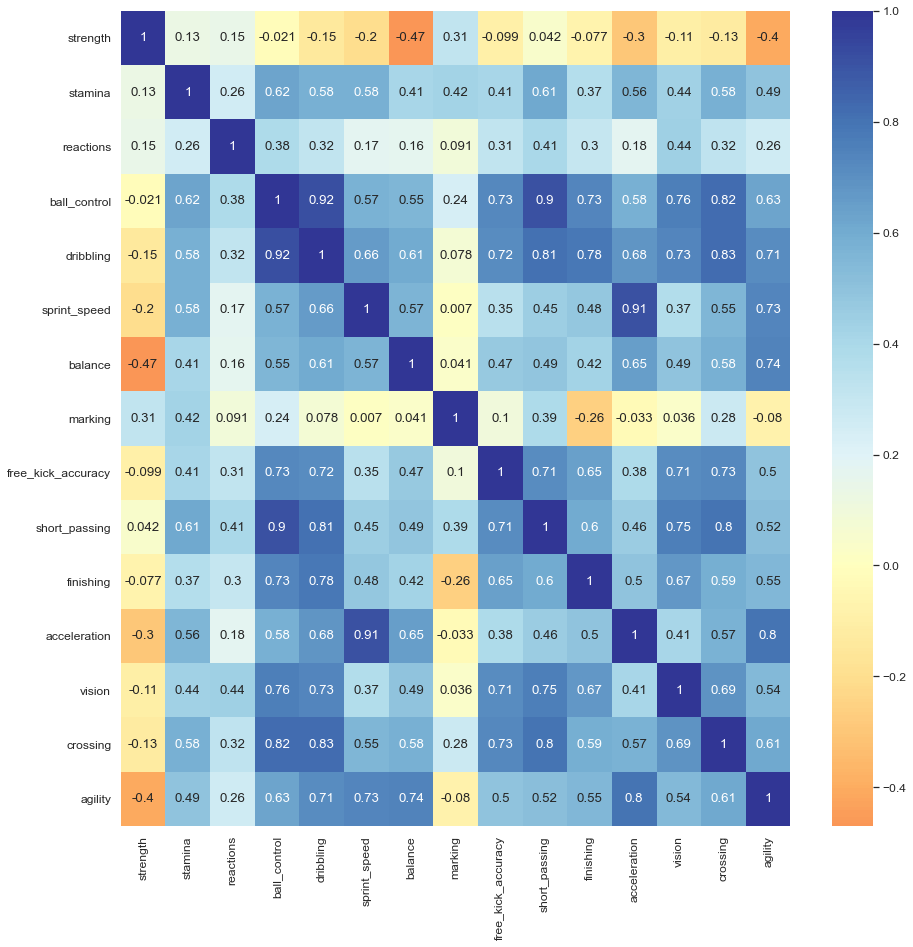

In [94]:
correlation_matrix = DF_TRAIN[cols].corr()
display(correlation_matrix)
plt.figure(figsize=(15,15))
sns.heatmap(data = correlation_matrix, center = 0, cmap = 'RdYlBu', annot = True);

### Analyzing if collinear/multicollinear features are present in your feature set

We can see at the heatmap that some features are have high value of correlation coefficient. Such features are:
* `dribbling` and `ball_control` - r = 0.92
* `sprint_speed` and `acceleration` - r = 0.91
* `short_passing` and `ball_control` - r = 0.90

However the high correlation coefficient doesn't imply that the features are multicollinear.
In order to detect if the collinear/multicollinear features are present in the feature set, let's first fit the model and check model weights using $L_2$-norm.

#### Fiting the model and calculating metrics on train and test sets

In [95]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train);

* explore fitted model parameters

In [96]:
model_intercept = model.intercept_
model_coef = model.coef_
print(f'model_intercept: {model_intercept}')
print(f'model_coef: {model_coef}')

model_intercept: 11.345545217120346
model_coef: [-0.14275039  0.06879623  0.12801522  0.02008191  0.11952043  0.0777467
  0.25671738 -0.06901863  0.02448576 -0.02029757 -0.0336813   0.32863138
  0.05856455  0.00901626]


* use fitted model to get predictions for test set

In [97]:
model_preds = model.predict(x_test)
model_preds

array([62.91721586, 81.27250118, 72.58337106, ..., 70.16950692,
       58.24731998, 69.98908288])

* explore model quality on train and test set

In [98]:
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,42.214903,4.943093,0.088309,0.774831
test,45.532007,5.090516,0.092009,0.769219


* For the test data:<br>
mse = 45.532007 - means that on average squared difference of actual values and predicted values amounts to 45.532007. <br>
mae = 5.090516 - means that on average predicted values differ from actual values by 5.090516.<br>
mape = 0.092009 - means that on average difference between predicted values and actual values amounts to 9,2%. <br>
r2 = 0.769219 - means that 76,9219% of variation of a dependent variable (`agility`) is explained by the independent variables in the regression model.

#### Calculate $L_2$-norm value for the model

In [99]:
l2_norm(model.coef_)

0.49654254569284134

* $L_2$-norm value is low, it means that our model weights are also low, this indicated that multicollinearity hasn't been detected. 
* According the model metric we can see that the metrics look good, it means that the `model_preds` aren't huge and on average close to the actual values of the target. It indicates that collinear/multicollinear features are absent in train data.

#### Let's use another way to verify that there're no collinear/multicollinear features in train data. Let's add some small delta to the features which may be collinear/multicollinear.

* Create and visualize sample of original train data

In [100]:
check = x_train.sample(5).copy()
check

,strength,stamina,reactions,ball_control,dribbling,sprint_speed,balance,marking,free_kick_accuracy,short_passing,finishing,acceleration,vision,crossing
10821,70.0,72.0,80.0,80.0,84.0,91.0,77.0,19.0,55.0,74.0,74.0,90.0,77.0,79.0
19470,72.0,58.0,64.0,58.0,60.0,67.0,52.0,28.0,57.0,59.0,62.0,54.0,57.0,39.0
39748,66.0,81.0,67.0,69.0,71.0,67.0,69.0,65.0,73.0,76.0,62.0,66.0,72.0,75.0
41483,61.0,68.0,57.0,63.0,64.0,75.0,63.0,17.0,32.0,63.0,67.0,74.0,61.0,52.0
32613,43.0,47.0,61.0,69.0,71.0,74.0,77.0,22.0,49.0,64.0,49.0,79.0,52.0,50.0


* Let's fit a Linear Regression model on this feature set

In [101]:
model = LinearRegression(fit_intercept=True)
fit_and_evaluate(model, x_train, y_train, x_test, y_test)

,mse,mae,mape,r2
train,42.214903,4.943093,0.088309,0.774831
test,45.532007,5.090516,0.092009,0.769219


In [102]:
print(f'intercept: {model.intercept_}')
print(f'coef: {model.coef_}')

intercept: 11.345545217120346
coef: [-0.14275039  0.06879623  0.12801522  0.02008191  0.11952043  0.0777467
  0.25671738 -0.06901863  0.02448576 -0.02029757 -0.0336813   0.32863138
  0.05856455  0.00901626]


* Let's generate predictions using our fitted model

In [103]:
check = x_test.head(5).copy()
check[target] = y_test.head(5)
check['preds'] = model.predict(check[features])
check

,strength,stamina,reactions,ball_control,dribbling,sprint_speed,balance,marking,free_kick_accuracy,short_passing,finishing,acceleration,vision,crossing,agility,preds
129220,66.0,47.0,58.0,60.0,61.0,63.0,65.0,47.0,66.0,68.0,42.0,64.0,55.0,47.0,56.0,62.917216
129231,56.0,70.0,66.0,64.0,63.0,81.0,81.0,26.0,66.0,60.0,65.0,86.0,60.0,62.0,91.0,81.272501
129260,80.0,60.0,64.0,69.0,73.0,79.0,62.0,15.0,64.0,64.0,67.0,82.0,62.0,68.0,78.0,72.583371
129262,69.0,76.0,61.0,82.0,79.0,81.0,74.0,32.0,35.0,76.0,74.0,80.0,66.0,50.0,82.0,76.136568
129286,53.0,49.0,72.0,80.0,81.0,85.0,76.0,26.0,45.0,67.0,76.0,82.0,55.0,60.0,77.0,79.872042


In [104]:
get_metrics(y_true=check[target], y_pred=check['preds'])

mse     42.888088
mae      6.159364
mape     0.081733
r2       0.676463
dtype: float64

* Predictions and metrics look reasonable

* Next let's add small delta to the `ball_control` feature and apply our model on new data.

In [105]:
delta = 1  # some small value
check['ball_control'] += delta
check['preds_2'] = model.predict(check[features])
check

,strength,stamina,reactions,ball_control,dribbling,sprint_speed,balance,marking,free_kick_accuracy,short_passing,finishing,acceleration,vision,crossing,agility,preds,preds_2
129220,66.0,47.0,58.0,61.0,61.0,63.0,65.0,47.0,66.0,68.0,42.0,64.0,55.0,47.0,56.0,62.917216,62.937298
129231,56.0,70.0,66.0,65.0,63.0,81.0,81.0,26.0,66.0,60.0,65.0,86.0,60.0,62.0,91.0,81.272501,81.292583
129260,80.0,60.0,64.0,70.0,73.0,79.0,62.0,15.0,64.0,64.0,67.0,82.0,62.0,68.0,78.0,72.583371,72.603453
129262,69.0,76.0,61.0,83.0,79.0,81.0,74.0,32.0,35.0,76.0,74.0,80.0,66.0,50.0,82.0,76.136568,76.156650
129286,53.0,49.0,72.0,81.0,81.0,85.0,76.0,26.0,45.0,67.0,76.0,82.0,55.0,60.0,77.0,79.872042,79.892124


In [106]:
get_metrics(y_true=check[target], y_pred=check['preds_2'])

mse     42.798377
mae      6.155347
mape     0.081712
r2       0.677140
dtype: float64

* We can realize that after adding small delta to the `ball_control` feature the presictions and metrics didn't change much from what they were for the original set of data. It proves that there is no multicollinearity in the data despite that `ball_control` has strong relationship with `dribbling` and `short_passing`.

Let's also check the `sprint_speed` and `acceleration` features the same way:

* Let's create a new sample of original train data, so that the previous changes of the `ball_control` feature wouldn't affect new predictions.

In [107]:
check = x_test.head(5).copy()
check[target] = y_test.head(5)
check['preds'] = model.predict(check[features])
check

,strength,stamina,reactions,ball_control,dribbling,sprint_speed,balance,marking,free_kick_accuracy,short_passing,finishing,acceleration,vision,crossing,agility,preds
129220,66.0,47.0,58.0,60.0,61.0,63.0,65.0,47.0,66.0,68.0,42.0,64.0,55.0,47.0,56.0,62.917216
129231,56.0,70.0,66.0,64.0,63.0,81.0,81.0,26.0,66.0,60.0,65.0,86.0,60.0,62.0,91.0,81.272501
129260,80.0,60.0,64.0,69.0,73.0,79.0,62.0,15.0,64.0,64.0,67.0,82.0,62.0,68.0,78.0,72.583371
129262,69.0,76.0,61.0,82.0,79.0,81.0,74.0,32.0,35.0,76.0,74.0,80.0,66.0,50.0,82.0,76.136568
129286,53.0,49.0,72.0,80.0,81.0,85.0,76.0,26.0,45.0,67.0,76.0,82.0,55.0,60.0,77.0,79.872042


* Let's add small delta to `sprint_speed` - one of our highly correlated features

In [108]:
delta = 1  # some small value
check['sprint_speed'] += delta
check['preds_3'] = model.predict(check[features])
check

,strength,stamina,reactions,ball_control,dribbling,sprint_speed,balance,marking,free_kick_accuracy,short_passing,finishing,acceleration,vision,crossing,agility,preds,preds_3
129220,66.0,47.0,58.0,60.0,61.0,64.0,65.0,47.0,66.0,68.0,42.0,64.0,55.0,47.0,56.0,62.917216,62.994963
129231,56.0,70.0,66.0,64.0,63.0,82.0,81.0,26.0,66.0,60.0,65.0,86.0,60.0,62.0,91.0,81.272501,81.350248
129260,80.0,60.0,64.0,69.0,73.0,80.0,62.0,15.0,64.0,64.0,67.0,82.0,62.0,68.0,78.0,72.583371,72.661118
129262,69.0,76.0,61.0,82.0,79.0,82.0,74.0,32.0,35.0,76.0,74.0,80.0,66.0,50.0,82.0,76.136568,76.214315
129286,53.0,49.0,72.0,80.0,81.0,86.0,76.0,26.0,45.0,67.0,76.0,82.0,55.0,60.0,77.0,79.872042,79.949789


In [109]:
get_metrics(y_true=check[target], y_pred=check['preds_3'])

mse     42.545258
mae      6.143814
mape     0.081653
r2       0.679049
dtype: float64

* Again we can realize that new pretictions and metrics haven't changed substantially

Taking into account $L_2$-norm value, metric values of the model, and findings of adding small delta to highly correlated with each other features, we can conclude that there's no collinear/multicollinear features in data.

### Make conclusion whether your model overfitted or not. Provide your arguments.

* Let's have a look at model quality on train and test set:

In [110]:
metrics = fit_and_evaluate(model, x_train, y_train, x_test, y_test)
metrics

,mse,mae,mape,r2
train,42.214903,4.943093,0.088309,0.774831
test,45.532007,5.090516,0.092009,0.769219


* Add the difference between test and train model metrics to a new row:

In [111]:
metrics.loc['Diff'] = metrics.loc['test'] - metrics.loc['train']
metrics

,mse,mae,mape,r2
train,42.214903,4.943093,0.088309,0.774831
test,45.532007,5.090516,0.092009,0.769219
Diff,3.317104,0.147423,0.003700,-0.005612


The metrics for the test set are slightly worse than for the train set. <br>
However the fact that it performs a bit worse on test set doesn't mean that the model is overfitting, because the model has learned based on the train set and isn't familiar with the test set. <br>
Overfitting generally occurs when a model is excessively complex, such as having too many parameters relative to the number of observations. 
As the difference between model metrics for train and test set isn't significant, the model has a reasonable number of parameters - 14 features, while the number of observations is large - 7407 observations, we can conclude that the model is not overfitted.

### Report about the work done

In order to a Linear regression model with multiple variables to predict `agility` variable, 14 featureas were chosen for the set of features. 10 of the features highly correlate with the target feature (r >= 0.5). However we founf out that some of the features have extemly strong relationship with each other: 
* `dribbling` and `ball_control` - r = 0.92 <br>
* `sprint_speed` and `acceleration` - r = 0.91 <br>
* `short_passing` and `ball_control` - r = 0.90 <br>

After analyzing these features for collinearity/multicollinearity, we came to a conclusion that there's no collinear/multicollinear features detected in the data. <br>
An explanation for high correlation of some of the features is that each vector of the features belong to one player, so the more trained and expirienced the player, the better values of the features they have.<br>
Then we fitted the model and calculated metrics on train and test sets. The metrics for the test set are slightly worse than for the train set. Despite that, the metrics show that the model performs well. R-squared for the test data is 76.9219%, it means that 76.9219% of the variance in the target variable - `agility` explained by the features in our regression model. <br>
However I suppose that there're several ways which could help to improve the model, for example, use sophisticated feature selection techniques, such as Stepwise Regression, Forward Selection, or Backward Elimination, use techniques to avoid overfitting when the model is tested on a different set of data, such as Cross-Validation, inspect features to find if there're some of them which add nothing to the model performance.